In [1]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [19]:
mlde_old = pd.read_csv("results/mlde/all_df_comb_onehot.csv")
mlde_ft = pd.read_csv("results/mlde_ft/vis/all_df.csv")
mlde_ft2 = pd.read_csv("results/mlde_ft2/vis/all_df.csv")
mlde_ft3 = pd.read_csv("results/mlde_ft3/vis/all_df.csv")

mlde_all = pd.concat([mlde_old, mlde_ft, mlde_ft2, mlde_ft3], axis=0)

In [20]:
from SSMuLA.landscape_global import LIB_TYPES

In [21]:
active_3 = [
    "DHFR",
    "ParD2",
    "ParD3",
    "TrpB3D",
    "TrpB3E",
    "TrpB3F",
    "TrpB3G",
    "TrpB3I",
]

In [22]:
active_4 = [
    "GB1",
    "TrpB4",
]

In [23]:
active_lib_list = active_3 + active_4

In [24]:
0.03125/2

0.015625

In [25]:
N_SAMPLE_LIST = [24, 48, 96, 192, 288, 384, 480, 576, 960, 1920]
FTLIB_FRAC_LIST = [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1]

In [26]:
# ft only 12.5
def get_mlde_avg_sdf(mlde_all, n_top, n_mut_cutoff, zs_list, active_lib_list, ft_frac = 0.125):
    slice_mlde = mlde_all[
        (mlde_all["lib"].isin(active_lib_list))
        & (mlde_all["zs"].isin(zs_list))
        & (mlde_all["n_top"] == n_top)
        & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
    ]

    if "none" not in zs_list:
        lib_dfs = []
        for lib in active_lib_list:
            lib_df = slice_mlde[slice_mlde["lib"] == lib].copy()
            print(lib, lib_df["ft_lib"].unique())
            lib_df["ft_lib_size"] = lib_df["ft_lib"].map(
                {
                    numb: frac
                    for numb, frac in zip(
                        sorted(lib_df["ft_lib"].unique()), FTLIB_FRAC_LIST[:-1]
                    )
                }
            )
            print(lib_df["ft_lib_size"].unique())
            lib_dfs.append(lib_df[lib_df["ft_lib_size"] == ft_frac])
        slice_mlde = pd.concat(lib_dfs)

    avg_mlde = slice_mlde[["n_sample", "top_maxes", "if_truemaxs", "zs", "ft_lib"]].groupby(["n_sample", "zs", "ft_lib"]).agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    avg_mlde = avg_mlde.rename(columns={'n_sample_': 'n_sample'}).set_index("n_sample")
    return avg_mlde

In [27]:
def get_mlde_avg_df(mlde_all, n_top, n_mut_cutoff, zs, active_lib_list):
    avg_mlde = mlde_all[
        (mlde_all["lib"].isin(active_lib_list))
        & (mlde_all["zs"].isin(zs))
        & (mlde_all["n_top"] == n_top)
        & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
    ][["n_sample", "top_maxes", "if_truemaxs", "zs"]].groupby(["n_sample", "zs"]).agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    avg_mlde = avg_mlde.rename(columns={'n_sample_': 'n_sample'}).set_index("n_sample")
    return avg_mlde

In [28]:
from SSMuLA.zs_analysis import ZS_OPTS
from SSMuLA.vis import PRESENTATION_PALETTE_SATURATE

%matplotlib inline

In [29]:
ZS_OPTS

['ed_score', 'Triad_score', 'ev_score', 'esm_score', 'esmif_score']

In [30]:
# for avg cross number of samples
n_top = 96
n_corr = 384

random_avg = get_mlde_avg_df(mlde_all, n_top, "all", ["none"], active_lib_list)
db = get_mlde_avg_df(mlde_all, n_top, "double", ["none"], active_lib_list)
db["zs_"] = "ed_score"

frac_ft_dict = {}

for frac in FTLIB_FRAC_LIST[:-1]:
    avg_mlde = get_mlde_avg_sdf(mlde_all, n_top, "all", ZS_OPTS, active_lib_list, ft_frac = frac)
    frac_ft_dict[frac] = avg_mlde

DHFR [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
ParD2 [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
ParD3 [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB3D [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB3E [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB3F [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB3G [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB3I [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
GB1 [80000 40000 20000 10000  2500  5000]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB4 [80000 40000 20000 10000  2500  5000]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
DHFR [4000 2000 1000  500  125  250]
[0.5     

In [31]:
db

,zs_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std
n_sample,,,,,
24,ed_score,0.690363,0.301229,0.1380,0.345073
48,ed_score,0.771400,0.261207,0.2140,0.410332
96,ed_score,0.855344,0.208015,0.3920,0.488258
192,ed_score,0.922755,0.143043,0.5750,0.494590
288,ed_score,0.937091,0.121463,0.6300,0.483046
384,ed_score,0.941383,0.113337,0.6446,0.478682
480,ed_score,0.943692,0.107340,0.6490,0.477522
576,ed_score,0.946117,0.105097,0.6630,0.472921
960,ed_score,0.947957,0.103761,0.6920,0.461898


In [32]:
frac_ft_dfs = []
for frac in FTLIB_FRAC_LIST[:-1]:
    frac_ft_dfs.append(frac_ft_dict[frac].loc[[96, 384]].reset_index().assign(ft_lib_size = frac))
frac_ft_dfs.append(random_avg.loc[[96, 384]].reset_index().assign(ft_lib_size = 1))
frac_ft_dfs.append(db.loc[[96, 384]].reset_index().assign(ft_lib_size = 1))
frac_ft_df = pd.concat(frac_ft_dfs).reset_index(drop=True)
frac_ft_df

,n_sample,zs_,ft_lib_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ft_lib_size
0,96,Triad_score,125.0,0.921792,0.167943,0.56625,0.495902,0.015625
1,96,Triad_score,2500.0,0.666504,0.127332,0.00500,0.070711,0.015625
2,96,esm_score,125.0,0.989529,0.040707,0.85750,0.349781,0.015625
3,96,esm_score,2500.0,0.717367,0.141067,0.06000,0.238083,0.015625
4,96,esmif_score,125.0,0.990816,0.045930,0.95125,0.215480,0.015625
...,...,...,...,...,...,...,...,...
95,384,ev_score,80000.0,0.773924,0.122255,0.10500,0.306937,0.500000
96,96,none,NaN,0.783289,0.284911,0.30700,0.461307,1.000000
97,384,none,NaN,0.881874,0.210293,0.49520,0.500027,1.000000
98,96,ed_score,NaN,0.855344,0.208015,0.39200,0.488258,1.000000


In [33]:
from SSMuLA.zs_analysis import ZS_OPTS_LEGEND

In [34]:
ZS_OPTS_LEGEND

{'none': 'Random',
 'ed_score': 'Edit distance',
 'Triad_score': 'Triad',
 'ev_score': 'EVmutation',
 'esm_score': 'ESM',
 'esmif_score': 'ESM-IF',
 'struc-comb_score': 'Triad + ESM-IF',
 'Triad-ev_score': 'Triad + EVmutation',
 'Triad-esm_score': 'Triad + ESM',
 'msanoif-comb_score': 'EVmutation + ESM',
 'msa-comb_score': 'EVmutation + ESM + ESM-IF',
 'structnmsa-comb_score': 'Triad + EVmutation + ESM + ESM-IF'}

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
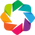

In [35]:
from SSMuLA.vis_summary import ZS_COLOR_MAP_APPENDED, ZS_OPTS_APPENDED

In [36]:
ZS_COLOR_MAP_APPENDED

{'none': '#666666',
 'Triad_score': '#4bacc6',
 'ev_score': '#9bbb59',
 'esm_score': '#8064a2',
 'esmif_score': '#ff8888',
 'struc-comb_score': '#849895',
 'msanoif-comb_score': '#9DAE88',
 'msa-comb_score': '#F1D384',
 'structnmsa-comb_score': '#C7B784',
 'double': '#f79646ff',
 'single': '#f9be00'}

In [37]:
PRESENTATION_PALETTE_SATURATE

{'blue': '#4bacc6',
 'orange': '#f79646ff',
 'light_orange': '#ffbb78',
 'red': '#ff8888',
 'maroon': '#7A303F',
 'green': '#9bbb59',
 'yellow': '#f9be00',
 'purple': '#8064a2',
 'brown': '#6e4a2eff',
 'gray': '#666666',
 'light_gray': '#D3D3D3',
 'light_blue': '#849895',
 'light_green': '#9DAE88',
 'light_yellow': '#F1D384',
 'light_brown': '#C7B784'}

In [38]:
five_zs = {'none': PRESENTATION_PALETTE_SATURATE["gray"],
 'ed_score': PRESENTATION_PALETTE_SATURATE["orange"],
 'Triad_score': PRESENTATION_PALETTE_SATURATE["blue"],
 'ev_score': PRESENTATION_PALETTE_SATURATE["green"],
 'esm_score': PRESENTATION_PALETTE_SATURATE["purple"],
 'esmif_score': PRESENTATION_PALETTE_SATURATE["yellow"]}

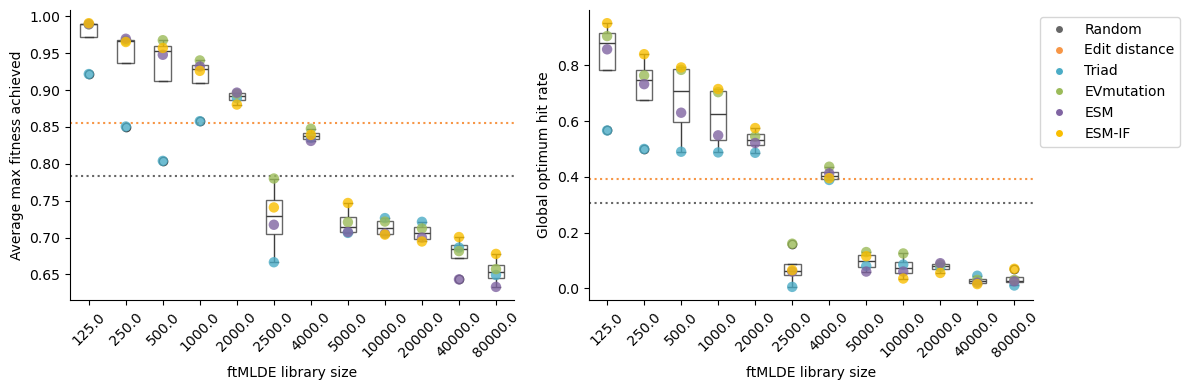

In [39]:
n_sample = 96

# mlde_color_list = ["yellow", "orange", "blue", "green", "purple", "red"]
ms = ["top_maxes_mean", "if_truemaxs_mean"]
titles = ["Average max fitness achieved", "Global optimum hit rate"]

slice_df = frac_ft_df[frac_ft_df["n_sample"] == n_sample].copy()

# Convert 'Category' column to categorical with defined order
slice_df['zs_'] = pd.Categorical(slice_df['zs_'], categories=list(five_zs.keys()), ordered=True)

# Sort DataFrame by 'Category'
slice_df = slice_df.sort_values(by='zs_')

fig, axes = plt.subplots(1, 2, figsize=(12, 4),)

for i, ax in enumerate(axes):

    ax.axhline(slice_df[slice_df["zs_"]=="none"][ms[i]].values[0], ls="dotted", color=five_zs["none"])
    ax.axhline(slice_df[slice_df["zs_"]=="ed_score"][ms[i]].values[0], ls="dotted", color=five_zs["ed_score"])

    sliced_df = slice_df[~slice_df["zs_"].isin(["none", "ed_score"])].copy()
    # sliced_df["ft_lib_size"] = sliced_df["ft_lib_size"] * 100

    ax = sns.stripplot(
        data=sliced_df,
        # x="ft_lib_size",
        x="ft_lib_",
        y=ms[i],
        hue="zs_",
        size=7.5,
        alpha=0.8,
        jitter=False,
        # style="ft_lib_size",
        marker='o',
        ax=ax,
        palette=list(five_zs.values()),
    )
    # ax.set_xscale("symlog")

    sns.boxplot(
        # x="ft_lib_size", 
        x= "ft_lib_",
        y=ms[i], 
        data=sliced_df,
        # showfliers=False,
        width=0.45, 
        boxprops={'facecolor': 'None', 'edgecolor': PRESENTATION_PALETTE_SATURATE["gray"]},
        # color=PRESENTATION_PALETTE_SATURATE["light_gray"],
        ax=ax,# palette="pastel", showmeans=True
        # order = np.linspace(0, 1, 9),
        # patch_artist=True
    )

    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("ftMLDE library size")
    ax.set_ylabel(titles[i])
    # ax.set_title(titles[i])
    # ax.set_xlim(0, 1)
    # 
    # ax.set_ylim(0.4, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_xticks(sliced_df["ft_lib_size"].unique())
   
    
axes[0].legend_.remove()  # Remove legend from the first subplot
legend_list = []
for zs, c in five_zs.items():
    legend_list.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, # markersize=10,
    label=ZS_OPTS_APPENDED[zs]))
axes[1].legend(handles=legend_list, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()

In [40]:
# split into 3 site and 4 site

# for avg cross number of samples
n_top = 96
n_corr = 384

random_3 = get_mlde_avg_df(mlde_all, n_top, "all", ["none"], active_3)
db_3 = get_mlde_avg_df(mlde_all, n_top, "double", ["none"], active_3)
db_3["zs_"] = "ed_score"

frac_ft_dict_3 = {}

for frac in FTLIB_FRAC_LIST[:-1]:
    avg_mlde = get_mlde_avg_sdf(mlde_all, n_top, "all", ZS_OPTS, active_3, ft_frac = frac)
    frac_ft_dict_3[frac] = avg_mlde

DHFR [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
ParD2 [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
ParD3 [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB3D [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB3E [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB3F [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB3G [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB3I [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
DHFR [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
ParD2 [4000 2000 1000  500  125  250]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
ParD3 [4000 2000 1000  500  125  250]
[0.5      0.25     

In [41]:
random_4 = get_mlde_avg_df(mlde_all, n_top, "all", ["none"], active_4)
db_4 = get_mlde_avg_df(mlde_all, n_top, "double", ["none"], active_4)
db_4["zs_"] = "ed_score"

frac_ft_dict_4 = {}

for frac in FTLIB_FRAC_LIST[:-1]:
    avg_mlde = get_mlde_avg_sdf(mlde_all, n_top, "all", ZS_OPTS, active_4, ft_frac = frac)
    frac_ft_dict_4[frac] = avg_mlde

GB1 [80000 40000 20000 10000  2500  5000]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB4 [80000 40000 20000 10000  2500  5000]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
GB1 [80000 40000 20000 10000  2500  5000]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB4 [80000 40000 20000 10000  2500  5000]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
GB1 [80000 40000 20000 10000  2500  5000]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB4 [80000 40000 20000 10000  2500  5000]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
GB1 [80000 40000 20000 10000  2500  5000]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB4 [80000 40000 20000 10000  2500  5000]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
GB1 [80000 40000 20000 10000  2500  5000]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
TrpB4 [80000 40000 20000 10000  2500  5000]
[0.5      0.25     0.125    0.0625   0.015625 0.03125 ]
GB1 [80000

In [42]:
frac_ft_dfs_3 = []
for frac in FTLIB_FRAC_LIST[:-1]:
    frac_ft_dfs_3.append(frac_ft_dict_3[frac].loc[[96, 384]].reset_index().assign(ft_lib_size = frac))
frac_ft_dfs_3.append(random_3.loc[[96, 384]].reset_index().assign(ft_lib_size = 1))
frac_ft_dfs_3.append(db_3.loc[[96, 384]].reset_index().assign(ft_lib_size = 1))
frac_ft_dfs_3 = pd.concat(frac_ft_dfs_3).reset_index(drop=True)
frac_ft_dfs_3

,n_sample,zs_,ft_lib_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ft_lib_size
0,96,Triad_score,125.0,0.921792,0.167943,0.566250,0.495902,0.015625
1,96,esm_score,125.0,0.989529,0.040707,0.857500,0.349781,0.015625
2,96,esmif_score,125.0,0.990816,0.045930,0.951250,0.215480,0.015625
3,96,ev_score,125.0,0.989151,0.045268,0.905000,0.293398,0.015625
4,384,Triad_score,125.0,0.943809,0.131081,0.672500,0.469595,0.015625
5,384,esm_score,125.0,0.999787,0.001973,0.980000,0.140088,0.015625
6,384,esmif_score,125.0,0.999456,0.011087,0.997500,0.049969,0.015625
7,384,ev_score,125.0,1.000000,0.000000,1.000000,0.000000,0.015625
8,96,Triad_score,250.0,0.850612,0.276141,0.500000,0.500313,0.031250
9,96,esm_score,250.0,0.969707,0.091003,0.732500,0.442932,0.031250


In [43]:
frac_ft_dfs_4 = []
for frac in FTLIB_FRAC_LIST[:-1]:
    frac_ft_dfs_4.append(frac_ft_dict_4[frac].loc[[96, 384]].reset_index().assign(ft_lib_size = frac))
frac_ft_dfs_4.append(random_4.loc[[96, 384]].reset_index().assign(ft_lib_size = 1))
frac_ft_dfs_4.append(db_4.loc[[96, 384]].reset_index().assign(ft_lib_size = 1))
frac_ft_dfs_4 = pd.concat(frac_ft_dfs_4).reset_index(drop=True)
frac_ft_dfs_4

,n_sample,zs_,ft_lib_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ft_lib_size
0,96,Triad_score,2500.0,0.666504,0.127332,0.0050,0.070711,0.015625
1,96,esm_score,2500.0,0.717367,0.141067,0.0600,0.238083,0.015625
2,96,esmif_score,2500.0,0.740862,0.128914,0.0650,0.247144,0.015625
3,96,ev_score,2500.0,0.780097,0.155592,0.1600,0.367526,0.015625
4,384,Triad_score,2500.0,0.746847,0.112442,0.0600,0.238083,0.015625
5,384,esm_score,2500.0,0.776624,0.129550,0.1150,0.319823,0.015625
6,384,esmif_score,2500.0,0.783194,0.126793,0.1450,0.352984,0.015625
7,384,ev_score,2500.0,0.916985,0.123037,0.5600,0.497633,0.015625
8,96,Triad_score,5000.0,0.706316,0.149584,0.0800,0.271974,0.031250
9,96,esm_score,5000.0,0.707461,0.149407,0.0600,0.238083,0.031250


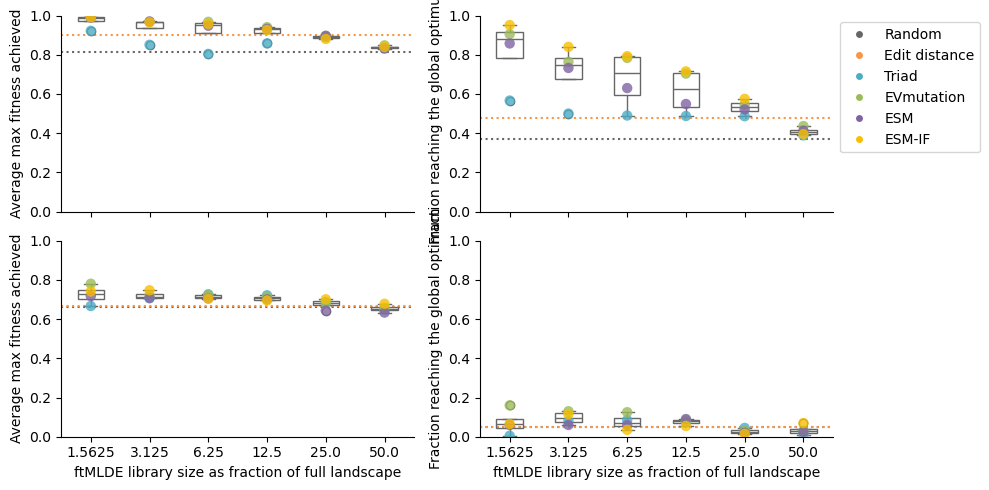

In [44]:
n_sample = 96

# mlde_color_list = ["yellow", "orange", "blue", "green", "purple", "red"]
ms = ["top_maxes_mean", "if_truemaxs_mean"]
titles = ["Average max fitness achieved", "Fraction reaching the global optimum"]

fig, axes = plt.subplots(2, 2, figsize=(10, 5), sharex=True)

for j, site in enumerate([3, 4]):

    frac_ft_df = frac_ft_dfs_3.copy() if site == 3 else frac_ft_dfs_4.copy()

    slice_df = frac_ft_df[frac_ft_df["n_sample"] == n_sample].copy()

    # Convert 'Category' column to categorical with defined order
    slice_df['zs_'] = pd.Categorical(slice_df['zs_'], categories=list(five_zs.keys()), ordered=True)

    # Sort DataFrame by 'Category'
    slice_df = slice_df.sort_values(by='zs_')

    for i in range(2):
        ax = axes[j, i] 

        ax.axhline(slice_df[slice_df["zs_"]=="none"][ms[i]].values[0], ls="dotted", color=five_zs["none"])
        ax.axhline(slice_df[slice_df["zs_"]=="ed_score"][ms[i]].values[0], ls="dotted", color=five_zs["ed_score"])

        sliced_df = slice_df[~slice_df["zs_"].isin(["none", "ed_score"])].copy()
        sliced_df["ft_lib_size"] = sliced_df["ft_lib_size"] * 100

        ax = sns.stripplot(
            data=sliced_df,
            x="ft_lib_size",
            # x="ft_lib_",
            y=ms[i],
            hue="zs_",
            size=7.5,
            alpha=0.8,
            jitter=False,
            # style="ft_lib_size",
            marker='o',
            ax=ax,
            palette=list(five_zs.values()),
        )
        # ax.set_xscale("symlog")

        sns.boxplot(
            x="ft_lib_size", 
            # x= "ft_lib_",
            y=ms[i], 
            data=sliced_df,
            # showfliers=False,
            width=0.45, 
            boxprops={'facecolor': 'None', 'edgecolor': PRESENTATION_PALETTE_SATURATE["gray"]},
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],
            ax=ax,# palette="pastel", showmeans=True
            # order = np.linspace(0, 1, 9),
            # patch_artist=True
        )

        # ax.tick_params(axis='x', rotation=45)
        ax.legend().set_visible(False)
        ax.set_xlabel("ftMLDE library size as fraction of full landscape")
        ax.set_ylabel(titles[i])
        # ax.set_title(titles[i])
        # ax.set_xlim(0, 1)
        # 
        ax.set_ylim(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.set_xticks(sliced_df["ft_lib_size"].unique())
    
        
# axes[0].legend_.remove()  # Remove legend from the first subplot
legend_list = []
for zs, c in five_zs.items():
    legend_list.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, # markersize=10,
    label=ZS_OPTS_APPENDED[zs]))
axes[0, 1].legend(handles=legend_list, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()